In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from bloch.bloch import bloch
import os.path

import matplotlib.pyplot as plt

In [2]:
pulse_df = pd.read_csv('SLRExcitShape.txt', sep="\s+", index_col=False, skip_blank_lines=True, names=['Amplitude', 'Phase'])
pulse_df

Amplitude       Phase
0     0.000000   67.444129
1     0.006015  180.000000
2     0.024243  180.000000
3     0.054956  180.000000
4     0.098385  180.000000
..         ...         ...
295   0.098385  180.000000
296   0.054956  180.000000
297   0.024243  180.000000
298   0.006015  180.000000
299   0.000000  180.000000

[300 rows x 2 columns]

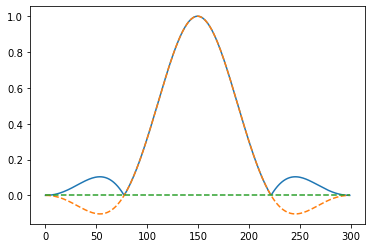

In [7]:
excite_cmplx = (pulse_df.Amplitude/pulse_df.Amplitude.max()).to_numpy()\
                * np.exp(1j * np.pi * (pulse_df.Phase/180.0).to_numpy())

plt.plot(np.abs(excite_cmplx))
plt.plot(excite_cmplx.real,'--')
plt.plot(excite_cmplx.imag,'--')

In [8]:
amp_int_rel = np.sum(excite_cmplx.real) / excite_cmplx.size
fa = 90
exc_pulse_dur = 0.75
pulse_length_exc = exc_pulse_dur / 1E3  # In s.
pulse_amp_hz = 500 * (1E-3/pulse_length_exc) * (fa/180) * (1/amp_int_rel)
print(pulse_amp_hz)
exc_pulse_hz = pulse_amp_hz * excite_cmplx

1411.5224159672775


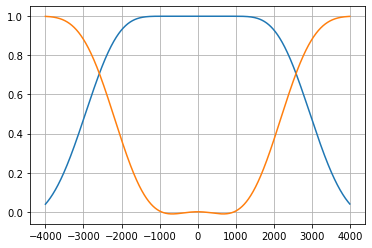

In [16]:
g = np.zeros(exc_pulse_hz.shape)

dt = (exc_pulse_dur / 1E3) / exc_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.grid()
plt.show()

## Refocussing pulse

In [22]:
ref_df = pd.read_csv('SechRfcShape.txt', sep=",", index_col=False, skip_blank_lines=True, names=['Amplitude', 'Phase'])
ref_df

Amplitude     Phase
0      1.005141  122.1846
1      1.010357  123.6676
2      1.015601  125.1505
3      1.020872  126.6334
4      1.026170  128.1164
...         ...       ...
2043   1.026170  128.1164
2044   1.020872  126.6334
2045   1.015601  125.1505
2046   1.010357  123.6676
2047   1.005141  122.1846

[2048 rows x 2 columns]

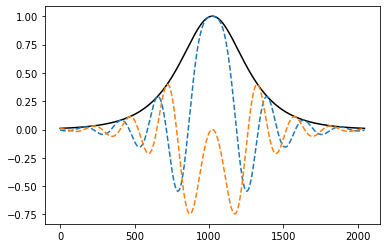

In [40]:
ref_cmplx = (ref_df.Amplitude/ref_df.Amplitude.max()).to_numpy()\
            * np.exp(1j * np.pi * (ref_df.Phase/180.0).to_numpy())

plt.plot(np.abs(ref_cmplx),'k')
plt.plot(ref_cmplx.real,'--')
plt.plot(ref_cmplx.imag,'--')
plt.show()

plt.plot(np.angle(ref_cmplx),'k')
plt.show()

fm = np.unwrap(np.angle(ref_cmplx))
fm *= 3/ref_cmplx.size
plt.plot(fm,'k')
plt.show()

In [36]:
ref_pulse_hz.shape

(2048,)

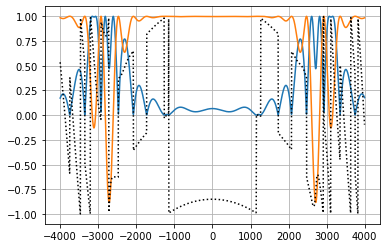

In [41]:
ref_pulse_dur = 3.0
ref_pulse_hz = ref_cmplx * 4000

g = np.zeros(ref_pulse_hz.shape)

dt = (ref_pulse_dur / 1E3) / ref_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.plot(df,np.angle(mx+1j*my)/np.pi,'k:')
plt.grid()
plt.show()

mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx, my, mz)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.plot(df,np.angle(mx+1j*my)/np.pi,'k:')
plt.grid()
plt.show()

In [51]:
# Adiabatic limit
B1_hz_vec = np.arange(100,5000,250)

mxy_store = []
mz_store = []
for b1 in B1_hz_vec:
    ref_pulse_hz = ref_cmplx * b1
    mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)
    mxy_store.append(np.abs(mx+1j*my))
    mz_store.append(mz)

mxy_store = np.concatenate(mxy_store,axis=1)
mz_store = np.concatenate(mz_store,axis=1)


In [72]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8),sharey=True)
ax1.contourf(df,B1_hz_vec,mxy_store.T, levels= np.arange(0,1.1,0.05))
ax2.contourf(df,B1_hz_vec,mz_store.T, levels= np.arange(-1.1,1.1,0.05))
ax1.set_ylabel('$\gamma B_1^+$ (Hz)')
ax1.set_xlabel('Off-resonance (Hz)')
ax2.set_xlabel('Off-resonance (Hz)')
ax1.set_title('$M_{xy}$')
ax2.set_title('$M_{z}$')
plt.show()